## Setup

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

from src.config import RAW_DATA_PATH
from src.train import ChurnModelTrainer

## Quick model comparison

In [2]:
# Load and prepare data
df = pd.read_csv(RAW_DATA_PATH / "WA_Fn-UseC_-Telco-Customer-Churn.csv")
trainer = ChurnModelTrainer()
X_train, X_val, X_test, y_train, y_val, y_test, encoder = trainer.prepare_data(df)

# Train baseline
baseline_model, scaler, baseline_auc = trainer.train_baseline(X_train, X_val, y_train, y_val)

# Train XGBoost
xgb_model, xgb_auc = trainer.train_xgboost(X_train, X_val, y_train, y_val)

print(f"Baseline AUC: {baseline_auc:.4f}")
print(f"XGBoost AUC: {xgb_auc:.4f}")
print(f"Improvement: {((xgb_auc - baseline_auc) / baseline_auc * 100):.1f}%")


2025-08-05 22:42:43 - src.train - INFO - Preparing data for training...
2025-08-05 22:42:43 - src.feature_engineering - WARNING - Found 11 rows with invalid TotalCharges. Imputing...
2025-08-05 22:42:43 - src.feature_engineering - INFO - Created 31 features
2025-08-05 22:42:43 - src.train - INFO - Train shape: (4225, 30), Val shape: (1409, 30), Test shape: (1409, 30)
2025-08-05 22:42:43 - src.train - INFO - Class distribution - Train: 26.53%, Val: 26.54%, Test: 26.54%
2025-08-05 22:42:43 - src.train - INFO - Training baseline model...
2025/08/05 22:42:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/opt/anaconda3/envs/ml-dev/lib/python3.9/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way t

Baseline AUC: 0.8399
XGBoost AUC: 0.8321
Improvement: -0.9%


## Visualize model performance

/opt/anaconda3/envs/ml-dev/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


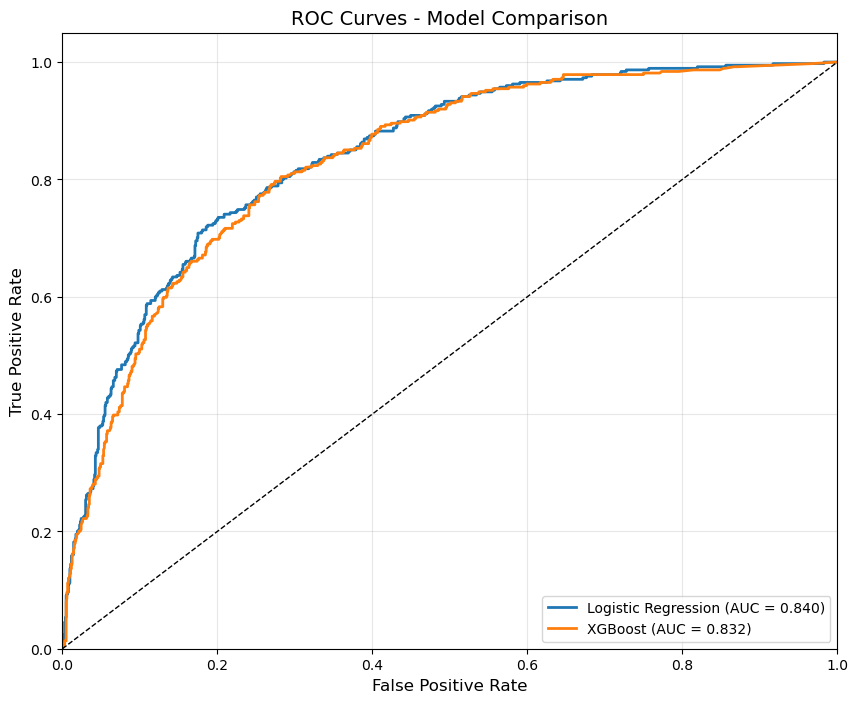

In [3]:
def plot_roc_curves(models, X_val, y_val, scaler=None):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        if name == 'Logistic Regression' and scaler:
            X_val_model = scaler.transform(X_val)
        else:
            X_val_model = X_val
            
        y_pred_proba = model.predict_proba(X_val_model)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, linewidth=2, 
                label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Plot ROC curves
models = {
    'Logistic Regression': baseline_model,
    'XGBoost': xgb_model
}
plot_roc_curves(models, X_val, y_val, scaler)

# Get feature importance

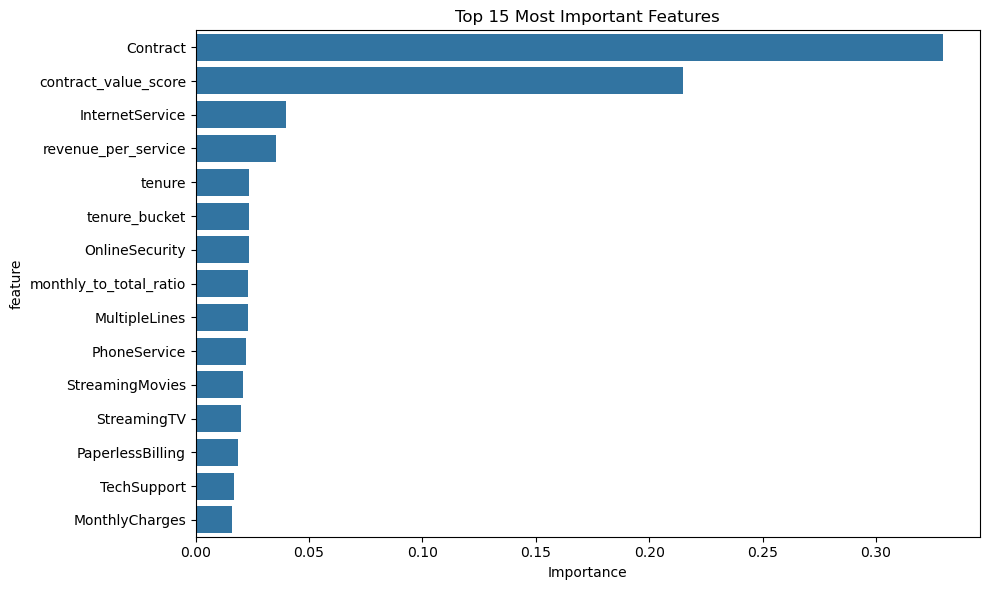

In [4]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, y='feature', x='importance')
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Model Complexity Analysis

/opt/anaconda3/envs/ml-dev/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-dev/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

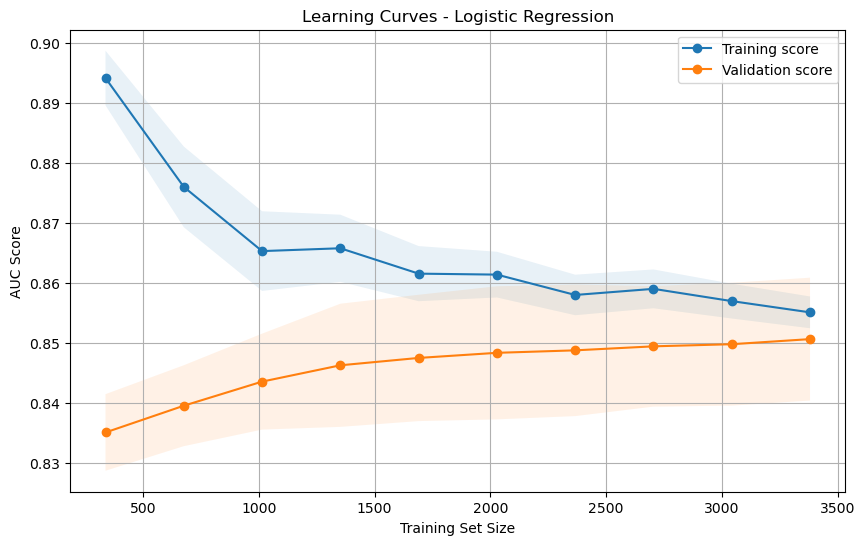

In [5]:
# 1. Learning curves
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc'
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation score')
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), 
                     alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('AUC Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for both models
plot_learning_curves(baseline_model, X_train, y_train, 
                    'Learning Curves - Logistic Regression')

# Business Value Optimization

/opt/anaconda3/envs/ml-dev/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
2025-08-05 22:45:42 - src.business_optimiser - INFO - Optimal threshold: 0.100


=== LOGISTIC REGRESSION BUSINESS ANALYSIS ===

        BUSINESS IMPACT REPORT - Logistic Regression
        
        Model Performance (Optimal Threshold: 0.100):
        - Customers to target: 863
        - Precision: 40.9% (of targeted customers, this % will actually churn)
        - Recall: 94.4% (of all churners, we'll catch this %)
        
        Financial Impact (Annual):
        - Total expected value: $62,686.00
        - Value per customer: $44.49
        - ROI: 726.4%
        
        Recommendations:
        1. Target customers with churn probability > 10.0%
        2. This will identify 353 actual churners
        3. Expected to retain 105 customers
        4. Budget needed: $8,630.00
        


--- Logging error ---
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ml-dev/lib/python3.9/logging/handlers.py", line 73, in emit
    if self.shouldRollover(record):
  File "/opt/anaconda3/envs/ml-dev/lib/python3.9/logging/handlers.py", line 191, in shouldRollover
    msg = "%s\n" % self.format(record)
  File "/opt/anaconda3/envs/ml-dev/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/Users/muhammadalisyed/Desktop/Work/Learning/Machine Learning/Projects/ml-engineering-training/churn-prediction/notebooks/../src/logger_config.py", line 100, in format
    return json.dumps(log_obj)
  File "/opt/anaconda3/envs/ml-dev/lib/python3.9/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/opt/anaconda3/envs/ml-dev/lib/python3.9/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/opt/anaconda3/envs/ml-dev/lib/python3.9/json/encoder.py", line 257, in iterencode


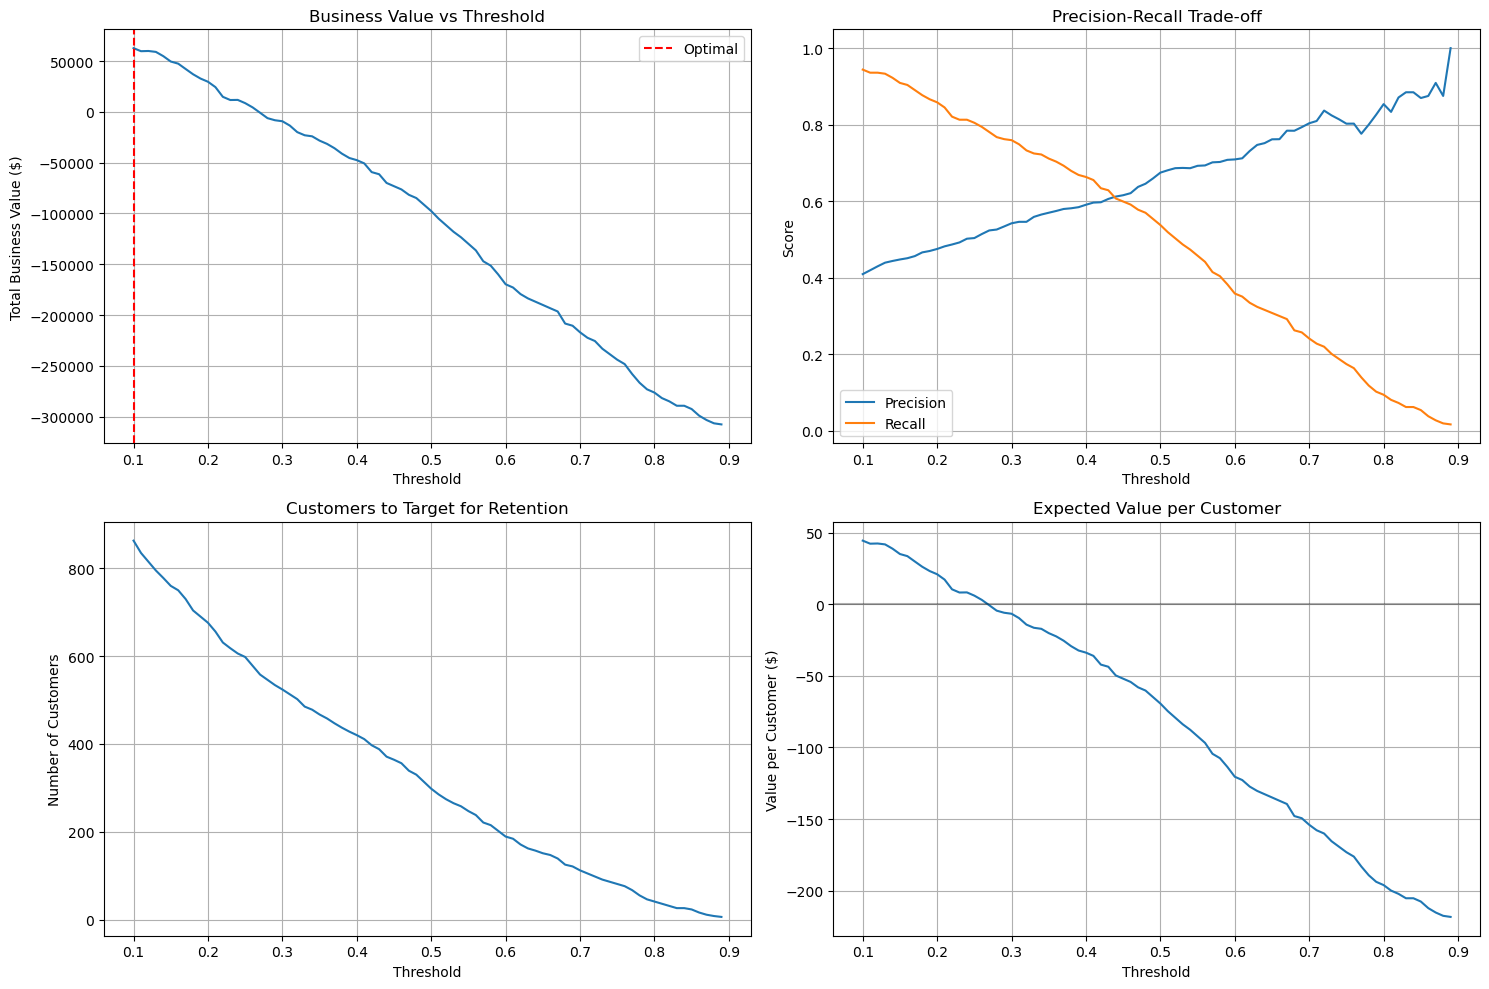


Improvement over default threshold: $160,334.00


/opt/anaconda3/envs/ml-dev/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [9]:
from src.business_optimiser import ChurnBusinessOptimiser

# Initialize with realistic business parameters
optimiser = ChurnBusinessOptimiser(
    monthly_revenue_per_customer=70,  # Average monthly revenue
    retention_cost=10,               # Cost of retention campaign
    retention_success_rate=0.3    # 30% success rate for retention
)

# Analyze the best model (logistic regression)
print("=== LOGISTIC REGRESSION BUSINESS ANALYSIS ===")
lr_metrics, lr_results = optimiser.create_business_report(
    baseline_model, 
    scaler.transform(X_test), 
    y_test,
    "Logistic Regression"
)

# Compare with default 0.5 threshold
default_metrics = optimiser.calculate_business_value(
    y_test, 
    baseline_model.predict_proba(scaler.transform(X_test))[:, 1], 
    0.5
)
print(f"\nImprovement over default threshold: ${lr_metrics['total_business_value'] - default_metrics['total_business_value']:,.2f}")